# Extrapolation with xesmf

When regridding data from one grid to another, it's common for the data to have different masks - you have one mask on the ocean grid for the ocean data and one mask on the atmosphere grid for the atmosphere data. These masks don't always line up perfectly if the data comes from different sources, so when we regrid there can be points missing along the coastline.

One way to work around this is to use extrapolation, extending the data so it covers the masked area. There are a couple ways to do this with ESMF_RegridWeightGen - you can just find the nearest unmasked point (`neareststod`), you can use some average of all nearby points weighted by distance (`nearestidavg`) or you can gradually reduce the size of the mask filling in grid cells with the mean of those around them (`creep`).

With the Pangeo variant of [`xesmf`](https://pangeo-xesmf.readthedocs.io/en/latest/index.html) installed in [hh5 Conda](http://climate-cms.wikis.unsw.edu.au/Conda) you can access these extrapolation methods directly from Python.

In [1]:
import xarray
import xesmf
import numpy

I'll start out with some sample data - in reality you'd read this from a file, I'll just use some random values from `numpy.random.random`. These two datasets are on different grids - dataset `a` is on a 10x15 grid, `b` on a 20x20 grid.

In [2]:
da_a = xarray.DataArray(numpy.random.random((10,15)), coords=[('lat', numpy.linspace(0,50, num=10)), ('lon', numpy.linspace(0,50,num=15))], name='a')
da_b = xarray.DataArray(numpy.random.random((20,20)), coords=[('lat', numpy.linspace(0,50, num=20)), ('lon', numpy.linspace(0,50,num=20))], name='b')

ds_a = da_a.to_dataset()
ds_b = da_a.to_dataset()

To use the xesmf extrapolation we need to specify the mask as a new variable in the dataset named `mask`. Again you'd read this from a file when working with a dataset - most datasets have a special mask file, or if the data is already masked you can access that mask with `.mask` on the array.

The mask needs to be `1` on the grid cells that are valid and `0` on the grid cells that are masked out.

In [3]:
ds_a['mask'] = (('lat', 'lon'), numpy.ones(ds_a.a.shape))
ds_a['mask'][0:5, 0:5] = 0

# I'm working a bit backwards and applying the mask I've just made to the data
ds_a['a'] = ds_a['a'].where(ds_a['mask'] == 1)

Now our 'a' data is masked in the bottom left corner, and we'd like to regrid it to the same grid as 'b', extrapolating to fill the masked area.

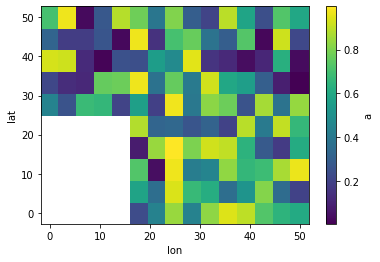

In [4]:
ds_a['a'].plot()

The 'pangeo' version of xesmf is installed in conda, which includes extrapolation. Make sure there is a `'mask'` variable in the source dataset if you want to use extrapolation.

https://pangeo-xesmf.readthedocs.io/en/latest/user_api.html

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


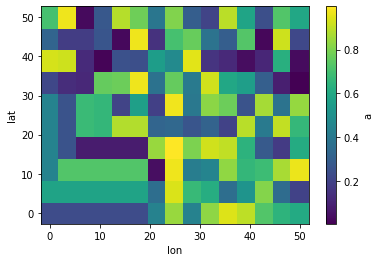

In [5]:
re = xesmf.Regridder(ds_a, ds_b, 'bilinear', extrap_method='nearest_s2d')
re.regrid_dataarray(ds_a['a']).plot()

You can see that the bottom corner has been filled in. Remember this isn't new information, it's only the nearby values copied over. 

The inverse distance extrapolation produces smoother results, there are a couple parameters that can be used to tune the averaging.

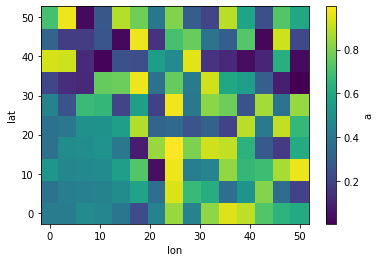

In [6]:
re2 = xesmf.Regridder(ds_a, ds_b, 'bilinear', extrap_method='inverse_dist')
re2.regrid_dataarray(ds_a['a']).plot()